In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [11]:
cd drive/My Drive/Colab Notebooks/Sprint19

/content/drive/My Drive/Colab Notebooks/Sprint19


In [2]:
import os
import glob
import random
import shutil
import warnings
import re
warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras.utils import np_utils, to_categorical
from keras.utils.vis_utils import plot_model

#from icrawler.builtin import GoogleImageCrawler

## 【問題1】自作データセットでの分類の学習
自作のデータセットに対して分類問題を解いてください。任意の実装を使用してください。

In [3]:
# 保存パス
root_dir = "./animals/"

# 検索キーワード
animals = ["dog", "cat"]

# 収集画像データ
data_count = 50

In [4]:
def crawl_image(animal, datacount, root_dir):
    crawler = GoogleImageCrawler(storage={"root_dir": root_dir + animal + "/train"})
    
    filters = dict(
                    size="large",
                    type="photo"
                    )
    
    #クローリングの実行
    crawler.crawl(
        keyword=animal,
        filters=filters,
        max_num=datacount
                )
    
    #前回実行時のtestディレクトリが存在する場合、ファイルを全て削除する
    if os.path.isdir(root_dir + animal + "/test"):
        shutil.rmtree(root_dir + animal + "/test")
    os.makedirs(root_dir + animal + "/test")
    
    #ダウンロードファイルのリストを取得
    filelist = glob.glob(root_dir + animal + "/train/*")
    #ダウンロード数の2割をtestデータとして抽出
    test_ratio = 0
    testfiles = random.sample(filelist, int(len(filelist) * test_ratio))
    
    for testfile in testfiles:
        shutil.move(testfile, root_dir + animal + "/test/")

In [5]:
# 画像データ収集
#for animal in animals:
#    crawl_image(animal, data_count, root_dir)

In [14]:
#学習データのファイルパスを取得
train_files = glob.glob(root_dir + "*/train/*.jpg")
train_files

['./animals/dog/train/000001.jpg',
 './animals/dog/train/000002.jpg',
 './animals/dog/train/000003.jpg',
 './animals/dog/train/000004.jpg',
 './animals/dog/train/000005.jpg',
 './animals/cat/train/000001.jpg',
 './animals/cat/train/000002.jpg',
 './animals/cat/train/000003.jpg',
 './animals/cat/train/000004.jpg',
 './animals/cat/train/000005.jpg']

In [15]:

def get_img_array(files):

    dog_img_array = np.empty((0,224,224,3))
    cat_img_array = np.empty((0,224,224,3))

    for img in files:
        # ファイル名に'dog'が含まれるイメージ
        if re.search('dog', img):
            dog_img_ = Image.open(img)
            try:
                # サイズを揃える
                dog_img_ = dog_img_.resize((224, 224))
                # PIL.Image.Imageからnumpy配列へ
                dog_img = np.array(dog_img_)
                # 正規化
                dog_img = dog_img / 255.
                # axisの追加
                dog_img = dog_img.reshape((1,224,224,3))
                dog_img_array = np.concatenate([dog_img_array, dog_img], axis = 0)
            except Exception as e:
                print(e,img)
            
            dog_img_.close()

        # ファイル名に'cat'が含まれるイメージ
        if re.search('cat', img):
            cat_img_ = Image.open(img)
            cat_img_ = cat_img_.resize((224, 224))
            cat_img = np.array(cat_img_)
            cat_img = cat_img / 255.
            cat_img = cat_img.reshape((1,224,224,3))
            cat_img_array = np.concatenate([cat_img_array, cat_img], axis = 0)
            cat_img_.close()
    
    X = np.concatenate([dog_img_array, cat_img_array], axis=0)
    y = np.array([0]*len(dog_img_array) + [1] * len(cat_img_array))
    
    return X, y

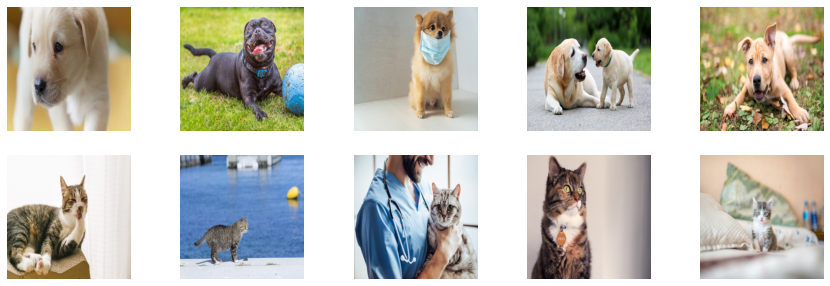

In [18]:
# 配列を画像として出力
X_train, y_train = get_img_array(train_files)

for i in range(len(X_train)):
    plt.rcParams['figure.figsize'] = (15.0, 5.0)
    plt.subplot(2,5,i+1)
    plt.imshow(X_train[i])
    plt.axis("off")
    
plt.show()

In [19]:
#学習時に一度リセット
keras.backend.clear_session()

#ハイパーパラメータ設定
batch_size = 10
epochs = 20

#モデルの構築
model = Sequential()
model.add(Conv2D(10, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.summary()

model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 10)      0         
_________________________________________________________________
flatten (Flatten)            (None, 123210)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                7885504   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

### 予測

In [65]:
test_files = glob.glob("./animals/*/test/*.jpg")
len(test_files)

79

In [52]:
X_test, y_test = get_img_array(test_files)

In [53]:
print(X_test.shape)
print(y_test.shape)

(79, 224, 224, 3)
(79,)


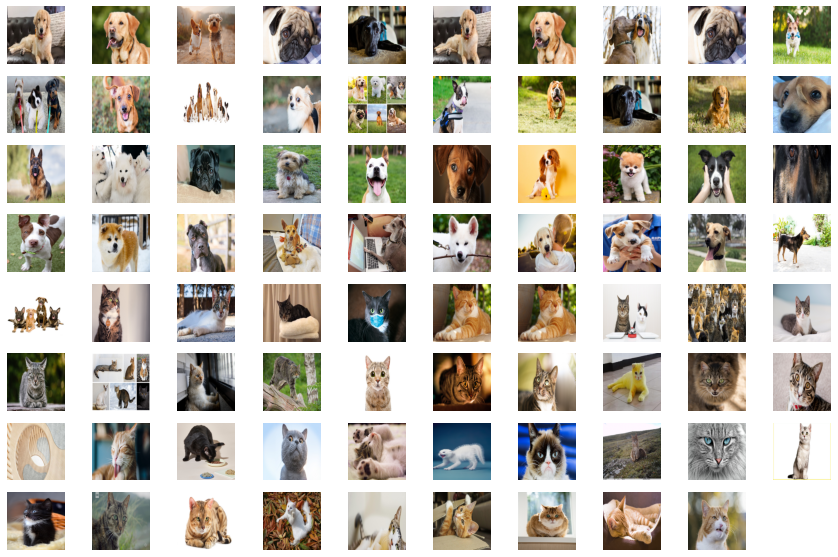

In [22]:
for i in range(len(X_test)):
    plt.rcParams['figure.figsize'] = (15.0, 10.0)
    plt.subplot(8,10,i+1)
    plt.imshow(X_test[i])
    plt.axis('off')
    
plt.show()

In [23]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 119ms/step - loss: 0.9914 - accuracy: 0.5696


[0.9914332628250122, 0.5696202516555786]

In [24]:
np.bincount(np.where(model.predict(X_test) > 0.5, 1, 0).flatten())

array([39, 40])

In [194]:
print(np.where(model.predict(X_test) > 0.5, 1, 0).flatten())
print(y_test)

[1 0 0 1 0 1 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0
 1 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


* 学習データ：5枚ずつ
* ミニバッチ数：１０
* エポック数：２０

* 正答率：57％

## 【問題2】分類データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。

《データ拡張のためのライブラリ》

データ拡張にはalbumentationsなどがあります。

[albu/albumentations: fast image augmentation library and easy to use wrapper around other libraries](https://github.com/albu/albumentations)

また、Kerasを使う場合はImageDataGeneratorも便利です。

《データ拡張の効果の調査》

データ拡張には様々な方法があります。今回のタスクにおいて各手法がどう効果があるかを実験・考察してください。

In [39]:
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

def img_augmentation(img_dir):
    img_files = glob.glob(img_dir + "/*.jpg")
    jpg       = ".jpg"         ## 拡張子
    
    save_path = img_dir + "/rotation/"  ## 生成された画像の格納path
    os.makedirs(save_path, exist_ok=True)   ## 格納先ディレクトリが存在しなければ作成する
    
    for path in img_files:
        # 1-1. テスト用画像の読み込み
        img = image.load_img(path)
        # 1-2. 画像の配列化
        img = np.array(img)
        # 2. 配列を四次元に整形
        img = img[np.newaxis]
        # 3. ジェネレータの定義
        # データ拡張のパターンを指定する
        glasses_gen = ImageDataGenerator(rotation_range = 60)
        # 4. ジェネレータを生成。
        gen = glasses_gen.flow(img, 
                             batch_size  = 1,         ## 起動バッチ数の指定。今回は画像1枚なので1
                             save_to_dir = save_path, ## 保存先ディレクトリのpath
                             save_format = "jpg"      ## 保存形式の指定
                            )

        plt.figure(figsize=(10,8))  # 表示画像サイズ

        # 5. 9枚の画像を生成する
        for i in range(9):
            # ジェネレータにおけるイテレータを進める
            batches = next(gen)
            # 1次元目は次元合わせだったので読み飛ばす。
            # 画像として表示するために、floatからuint8に変換する。
            g_img = batches[0].astype(np.uint8)


In [40]:
#rotationデータ作成
train_dirs = ["./animals/dog/train", "./animals/cat/train"]
for train_dir in train_dirs:
  img_augmentation(train_dir)

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

<Figure size 720x576 with 0 Axes>

In [75]:
rotation_files = glob.glob("./animals/*/train/rotation/*.jpg")
X_train, y_train = get_img_array(rotation_files)

In [77]:
print(X_train.shape)
print(y_train.shape)

(90, 224, 224, 3)
(90,)


In [78]:
#学習時に一度リセット
keras.backend.clear_session()

#ハイパーパラメータ設定
batch_size = 10
epochs = 20

#モデルの構築
model = Sequential()
model.add(Conv2D(10, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.summary()

model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 10)      0         
_________________________________________________________________
flatten (Flatten)            (None, 123210)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                7885504   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

### 予測

In [81]:
model.evaluate(X_test, y_test)
print(np.where(model.predict(X_test) > 0.5, 1, 0).flatten())
print(y_test)

3/3 [==============================] - 0s 123ms/step - loss: 3.6328 - accuracy: 0.6076
[0 0 0 1 0 0 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0
 1 1 0 1 1 1 0 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 0 0
 1 0 1 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]


画像の回転を行い、データの水増しをすることで正答率４％の精度改善  
判定対象の写る角度の違いを学習できたことによる改善だと考えられる


In [86]:
#様々な画像の種類を生成してみる
def img_augmentation2(img_dir):
    img_files = glob.glob(img_dir + "/*.jpg")
    jpg       = ".jpg"         ## 拡張子
    
    save_path = img_dir + "/various/"  ## 生成された画像の格納path
    os.makedirs(save_path, exist_ok=True)   ## 格納先ディレクトリが存在しなければ作成する
    
    for path in img_files:
        # 1-1. テスト用画像の読み込み
        img = image.load_img(path)
        # 1-2. 画像の配列化
        img = np.array(img)
        # 2. 配列を四次元に整形
        img = img[np.newaxis]
        # 3. ジェネレータの定義
        # データ拡張のパターンを指定する
        glasses_gen = ImageDataGenerator(rotation_range    = 50,  ## 回転角度の変更域の指定
                               width_shift_range   = 0.3, ## 水平方向への移動域の指定
                               height_shift_range  = 0.3, ## 垂直方向への移動域の指定
                               shear_range         = 0.1, ## 傾斜角度の変更域の指定
                               zoom_range          = 0.3, ## 拡大率の変更域の指定
                               channel_shift_range = 100, ## チャンネル変化の指定
                               
                              )
        # 4. ジェネレータを生成。
        gen = glasses_gen.flow(img, 
                             batch_size  = 1,         ## 起動バッチ数の指定。今回は画像1枚なので1
                             save_to_dir = save_path, ## 保存先ディレクトリのpath
                             save_format = "jpg"      ## 保存形式の指定
                            )

        plt.figure(figsize=(10,8))  # 表示画像サイズ

        # 5. 9枚の画像を生成する
        for i in range(9):
            # ジェネレータにおけるイテレータを進める
            batches = next(gen)
            # 1次元目は次元合わせだったので読み飛ばす。
            # 画像として表示するために、floatからuint8に変換する。
            g_img = batches[0].astype(np.uint8)


In [ ]:
#variousデータ作成
train_dirs = ["./animals/dog/train", "./animals/cat/train"]
for train_dir in train_dirs:
  img_augmentation2(train_dir)

In [101]:
various_files = glob.glob("./animals/*/train/various/*.jpg")
X_train, y_train = get_img_array(various_files)

In [102]:
print(X_train.shape)
print(y_train.shape)

(90, 224, 224, 3)
(90,)


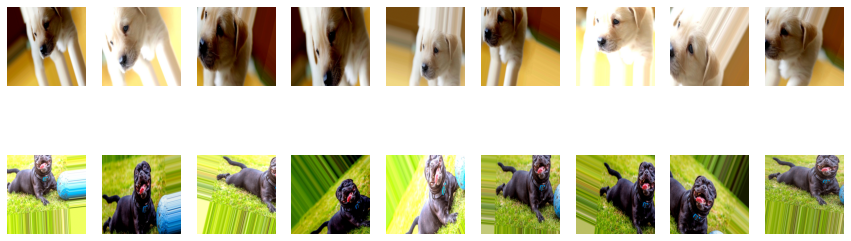

In [110]:
for i in range(18):
  plt.rcParams['figure.figsize'] = (15.0, 5.0)
  plt.subplot(2,9,i+1)
  plt.imshow(X_train[i])
  plt.axis("off")
plt.show()

In [111]:
#学習時に一度リセット
keras.backend.clear_session()

#ハイパーパラメータ設定
batch_size = 10
epochs = 20

#モデルの構築
model = Sequential()
model.add(Conv2D(10, (3, 3), activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

model.summary()

model.compile(loss="binary_crossentropy", optimizer="adam", metrics="accuracy")

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 10)      280       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 10)      0         
_________________________________________________________________
flatten (Flatten)            (None, 123210)            0         
_________________________________________________________________
dense (Dense)                (None, 64)                7885504   
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0

In [112]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 128ms/step - loss: 4.9272 - accuracy: 0.6203


[4.92722225189209, 0.6202531456947327]

回転、暗転、拡大・縮小など様々のデータの水増しをすることで正答率６％の精度改善  
判定対象の写る角度の違いを学習できたことによる改善だと考えられる


## 【問題3】物体検出データセットの用意
次に、物体検出を行います。バウンディングボックスのアノテーションを行い物体検出のためのデータセットを作成してください。

《アノテーションのためのツール》

アノテーションツールにはLabelImgなどがあります。

[tzutalin/labelImg: LabelImg is a graphical image annotation tool and label object bounding boxes in images](https://github.com/tzutalin/labelImg)

In [255]:
import random
import cv2
from matplotlib import pyplot as plt
import albumentations as A
import xml.etree.ElementTree as ET
!pip install -U git+https://github.com/albu/albumentations --no-cache-dir

In [127]:
BOX_COLOR = (255, 0, 0) # Red
TEXT_COLOR = (255, 255, 255) # White

def visualize_bbox(img, bbox, class_name, color=BOX_COLOR, thickness=2):
    """Visualizes a single bounding box on the image"""
    x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(x_min), int(x_min + w), int(y_min), int(y_min + h)
   
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(
        img,
        text=class_name,
        org=(x_min, y_min - int(0.3 * text_height)),
        fontFace=cv2.FONT_HERSHEY_SIMPLEX,
        fontScale=0.35, 
        color=TEXT_COLOR, 
        lineType=cv2.LINE_AA,
    )
    return img

def visualize(image, bboxes, category_ids, category_id_to_name):
    img = image.copy()
    for bbox, category_id in zip(bboxes, category_ids):
        class_name = category_id_to_name[category_id]
        img = visualize_bbox(img, bbox, class_name)
    plt.figure(figsize=(12, 12))
    plt.axis('off')
    plt.imshow(img)

In [249]:
xml_files = glob.glob("./train/*/*.xml")

for file in xml_files:
  with open(file, "r") as f:
    image = cv2.imread(re.sub(".xml", ".jpg", file))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #xmlデータを読み込み
    tree = ET.parse(file)
    #一番上の階層を取り出し
    root = tree.getroot()
    x_min = int(root[6][4][0].text)
    y_min = int(root[6][4][1].text)
    w     = int(root[6][4][2].text) - x_min
    h     = int(root[6][4][2].text) - y_min

    if re.search("dog", file):
      class_name = "dog"
    else:
      class_name = "cat"

    bbox  = (x_min, y_min, w, h)
    image = visualize_bbox(image, bbox, class_name)
    cv2.imwrite(re.sub(".xml", "_bbox.jpg", file), image)

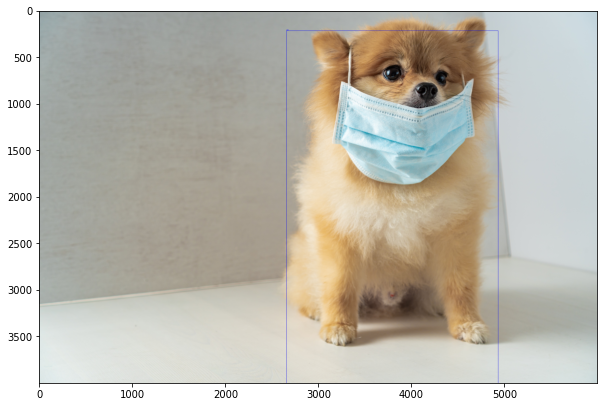

In [248]:
plt.rcParams["figure.figsize"] = (10, 10)
img = Image.open("./train/dog/dog_000003_bbox.jpg")
plt.imshow(img)
img.close()

## 【問題4】物体検出データセットに対するデータ拡張
データ拡張（Data Augmentation）を行ってください。前述のalbumentationsはバウンディングボックスを合わせての加工が可能です。詳細はREADME.mdを確認してください。

物体検出の学習を行なうかどうかは任意とします。

In [268]:
from keras.preprocessing import image
#様々な画像の種類を生成してみる
def img_augmentation2(img_dir):
    img_files = glob.glob(img_dir + "/*_bbox.jpg")
    jpg       = ".jpg"         ## 拡張子
    
    save_path = img_dir + "/bbox_augmentation/"  ## 生成された画像の格納path
    os.makedirs(save_path, exist_ok=True)   ## 格納先ディレクトリが存在しなければ作成する
    
    for path in img_files:
        # 1-1. テスト用画像の読み込み
        img = image.load_img(path)
        # 1-2. 画像の配列化
        img = np.array(img)
        # 2. 配列を四次元に整形
        img = img[np.newaxis]
        # 3. ジェネレータの定義
        # データ拡張のパターンを指定する
        glasses_gen = ImageDataGenerator(rotation_range    = 50,  ## 回転角度の変更域の指定
                               width_shift_range   = 0.3, ## 水平方向への移動域の指定
                               height_shift_range  = 0.3, ## 垂直方向への移動域の指定
                               shear_range         = 0.1, ## 傾斜角度の変更域の指定
                               zoom_range          = 0.3, ## 拡大率の変更域の指定
                               channel_shift_range = 100, ## チャンネル変化の指定
                               
                              )
        # 4. ジェネレータを生成。
        gen = glasses_gen.flow(img, 
                             batch_size  = 1,         ## 起動バッチ数の指定。今回は画像1枚なので1
                             save_to_dir = save_path, ## 保存先ディレクトリのpath
                             save_format = "jpg"      ## 保存形式の指定
                            )

        plt.figure(figsize=(10,8))  # 表示画像サイズ

        # 5. 9枚の画像を生成する
        for i in range(9):
            # ジェネレータにおけるイテレータを進める
            batches = next(gen)
            # 1次元目は次元合わせだったので読み飛ばす。
            # 画像として表示するために、floatからuint8に変換する。
            g_img = batches[0].astype(np.uint8)

In [ ]:
bbox_dir = "./train/*"
img_augmentation2(bbox_dir)

In [282]:
aug_files = glob.glob("./train/*/bbox_augmentation/*")

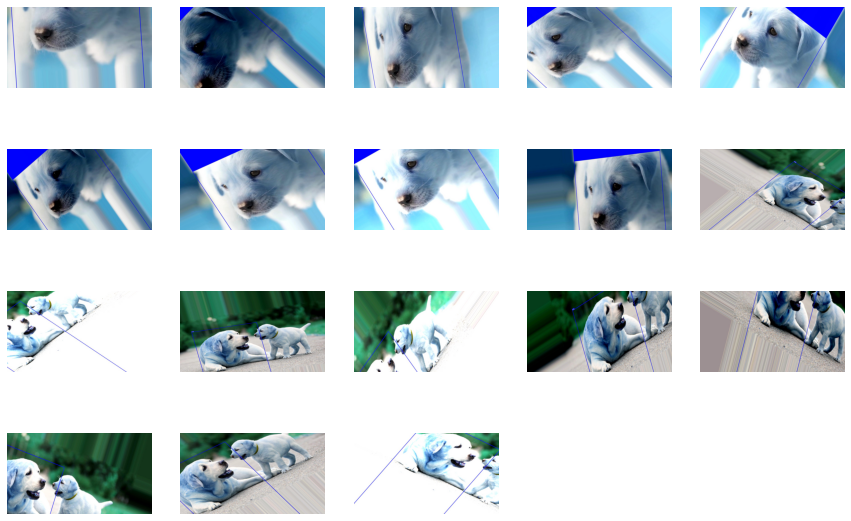

In [290]:
for i, file in enumerate(aug_files):
  plt.rcParams['figure.figsize'] = (15.0, 10.0)
  plt.subplot(4,5,i+1)
  im = Image.open(file)
  plt.imshow(im)
  plt.axis('off')
  if i == 17:
    break
    
plt.show()